# Least cost paths <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** This notebook loads data from an external raster file (`canberra_dem_250m.tif`) from the `Supplementary_data` folder of this repository


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [58]:
import numpy as np
from skimage.graph import route_through_array
import matplotlib.pyplot as plt
import xarray as xr

In [59]:
# image_da = xr.DataArray(image, coords=(-np.arange(3000, 3500), np.arange(1000, 1500)), dims=['y', 'x'])

# Synthetic example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


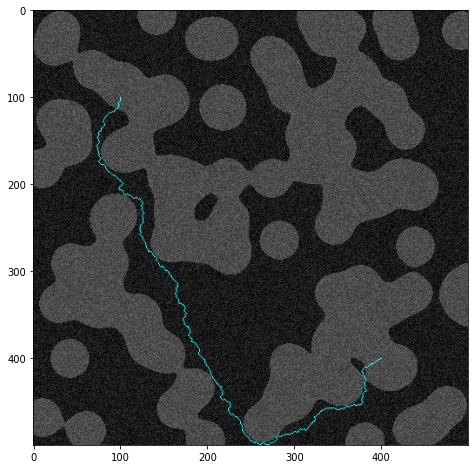

In [60]:
from skimage import data
from numpy.random import rand
image = data.binary_blobs(length=500) 
image = (image.astype(float)/(image.max()) + rand(*image.shape)) / 2.0

# Find the path with lowest cost
indices, weight = route_through_array(image, (100, 100), (-100, -100))
indices = np.stack(indices, axis=-1)
path = np.zeros_like(image)
path[indices[0], indices[1]] = 1

plt.figure(figsize=(8,8))
plt.imshow(np.stack([image * 0.4, path + image * 0.4, path + image * 0.4], axis=2))

# Datacube example

In [61]:
import datacube
dc = datacube.Datacube(app="Reprojecting_data")

import sys
sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

In [62]:
# Create a reusable query
query = {
    'x': ( 152.33, 152.390074),
    'y': (-24.724930, -24.742972),
    'time': ('1998-06', '1999-06'),
    'measurements': [
        'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1',
        'nbart_swir_2'
    ],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc, products=['ga_ls5t_ard_3'], min_gooddata=0.99, **query)

Finding datasets
    ga_ls5t_ard_3
Counting good quality pixels for each time step
Filtering to 10 out of 19 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 10 time steps


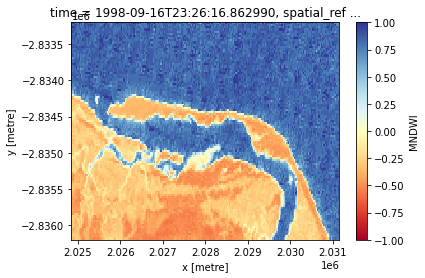

In [63]:
# Calculate NDVI using the formula above
# da = (ds.nbart_nir - ds.nbart_red) / (ds.nbart_nir + ds.nbart_red)
da = calculate_indices(ds, index='MNDWI', collection='ga_ls_3').MNDWI

# Plot the results for one time step to see what they look like:
da = da.isel(time=3)
da.plot(vmin=-1, vmax=1, cmap='RdYlBu')

In [114]:
coords_start_crs = 2028291.63892949, -2834524.95323676
coords_end_crs = 2029000.99446205, -2834623.37507558
coords_start = ~da.geobox.transform * coords_start_crs
coords_end = ~da.geobox.transform * coords_end_crs

In [115]:
# Find the path with lowest cost
image = ((da.where(da < 0.5, 100) + 1) / 2)
# image = (1 - (da.where((da > -0.5) & (da < 0.5))  + 1) / 2) * 0.5
# image = (-np.log2(((da + 1) / 2)))
indices, weight = route_through_array(image.values, [int(x) for x in coords_start[::-1]], [int(x) for x in coords_end[::-1]])
indices = np.stack(indices, axis=-1)
path = np.zeros_like(image)
path[indices[0], indices[1]] = 1


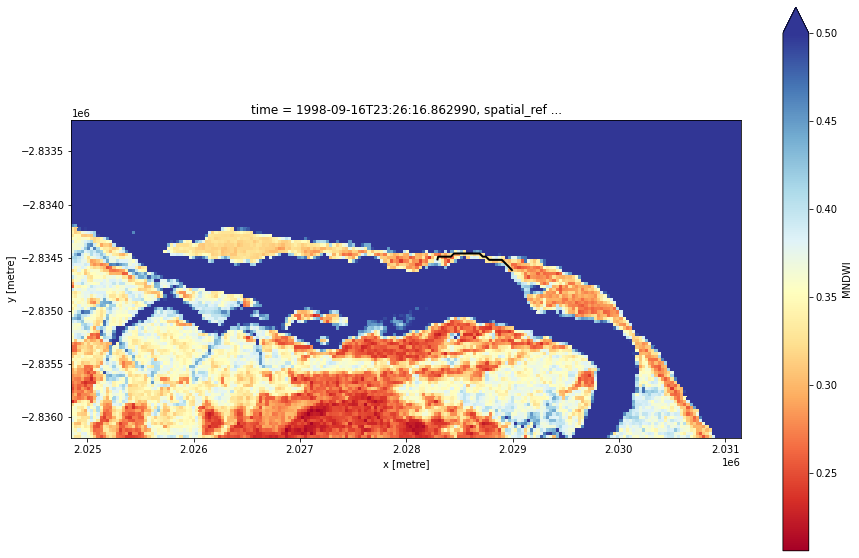

In [116]:
from shapely.geometry import Point, LineString
import geopandas as gpd

# Reproject indices
indices_crs = [da.geobox.transform * i for i in indices.T[:, (1, 0)]]
indices_crs[0] = coords_start_crs
indices_crs[-1] = coords_end_crs

geom = LineString(indices_crs)
image.plot(size=10, cmap = 'RdYlBu', vmax=0.5)
path_gs = gpd.GeoSeries(geom)
path_gs.plot(ax=plt.gca(), color='black', linewidth=2)

# plt.figure()
# image.plot.hist()

In [117]:
print(path_gs.geometry.length / weight) 
print((path_gs.geometry.length / weight) > 50)

0    97.108083
dtype: float64
0    True
dtype: bool


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [22]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)